In [6]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

In [7]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27
e3 = 642121496772645.10
e2 = 688358979309307.82
omega = 2.0*np.pi*1.0e6 #*650e3
m = 170.936331517*amutokg
eta = (2.*np.pi*e3/c)*np.sqrt(hbar/(2.*m*omega))
print(eta)
eta = 0.05

Ncut = 2001
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

0.07317585153349442


In [8]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27


def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(n): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*650e3 #Our trap
    Omegarf = 2.0*np.pi*16.026e6 #Our trap
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*hbar*omega*(0.5+n)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

Ncut = 2001
dopAndStarks = np.zeros(Ncut)
ns = np.linspace(0,Ncut-1,Ncut)
for ii in range(Ncut):
    dopAndStarks[ii] = dopAndStark(ns[ii])

In [9]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [10]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

In [16]:
delPrimes = 2.0*np.pi*np.linspace(-5,5,25)
delpts = np.size(delPrimes)
nbarf = 80.

shifts1 = np.zeros(delpts)
shifts2 = np.zeros(delpts)
T = 150e-3
Omega0 = np.pi/(2*24.5e-3)
Ncut = 500

psi0 = psi(1.+0.j,0.+0.j)
x0 = -0.6*2*np.pi
x1 = 0.6*2*np.pi
guessTol = 5.0
tol = 1e-6
for ii in range(delpts):
    shifts1[ii] = root(HR, args=(psi0, 79e-3, T, 22e-3, delPrimes[ii], delPrimes[ii], Omega0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    shifts2[ii] = root(HR, args=(psi0, 79e-3, T, 32.5e-3, delPrimes[ii], delPrimes[ii], Omega0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    print([x0,x1])

1.6236165989050821
[np.float64(-3.3649844898859365), np.float64(6.635015510114064)]
1.3405463135653752
[np.float64(-3.6487018501288073), np.float64(6.351298149871193)]
1.0859417780091571
[np.float64(-3.903971699743649), np.float64(6.096028300256351)]
0.8603156471262343
[np.float64(-4.130296619913221), np.float64(5.869703380086779)]
0.6639458866555576
[np.float64(-4.327413940773053), np.float64(5.672586059226947)]
0.49672798922002165
[np.float64(-4.495442519692929), np.float64(5.504557480307071)]
0.3580070925243691
[np.float64(-4.635049442816169), np.float64(5.364950557183831)]
0.2464040224829426
[np.float64(-4.747622474095041), np.float64(5.252377525904959)]
0.15965862097789713
[np.float64(-4.835425057665527), np.float64(5.164574942334473)]
0.0945221554529295
[np.float64(-4.901702393817212), np.float64(5.098297606182788)]
0.04673400362917251
[np.float64(-4.950703835525717), np.float64(5.049296164474283)]
0.011111667170562105
[np.float64(-4.98759300194457), np.float64(5.01240699805543)]

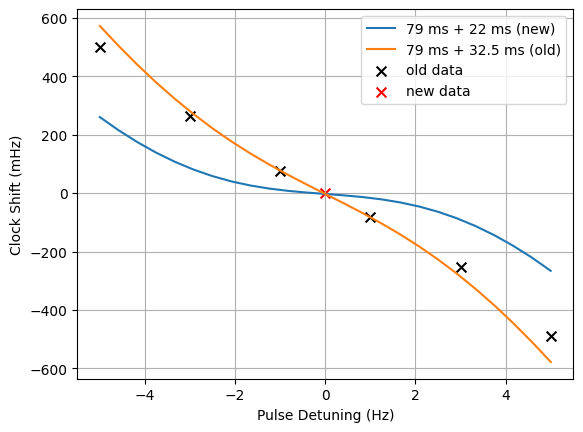

In [21]:
plt.plot(delPrimes/(2*np.pi),1e3*shifts1/(2*np.pi),label="79 ms + 22 ms (new)")
plt.plot(delPrimes/(2*np.pi),1e3*shifts2/(2*np.pi),label="79 ms + 32.5 ms (old)")
plt.scatter([1,-1,3,-3,5,-5],[-82.4,77.0,-253.2,264.9,-490.6,498.5],color="black",marker="x",s=50,label="old data")
#-------------enter data here-------------------
plt.scatter([0],[0],color="red",marker="x",s=50,label="new data")
plt.xlabel("Pulse Detuning (Hz)")
plt.ylabel("Clock Shift (mHz)")
plt.legend()
plt.grid()